<a href="https://colab.research.google.com/github/matteoturnu/NetSecProject/blob/main/NetSec_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Esercizio Martalò


In [1]:
!pip install pandas
!pip install numpy

import pandas as pd
import numpy as np

# Import the dataset and create a dataframe
traffic_df = pd.read_csv("Train_Test_Network.csv")
print(traffic_df.columns)

# We need to isolate the fields of interest
clean_df = traffic_df[["proto", "label", "type"]]
print(clean_df)

feature = "type"
analysis_df = clean_df[feature]
print("analysis_df: ", analysis_df)
# counts the unique values for the selected feature and order them
val_count = analysis_df.value_counts().sort_index()
print(val_count)


FileNotFoundError: [Errno 2] No such file or directory: 'Train_Test_Network.csv'

In [ ]:
# Try to extract some statistics
type_proto_counts = clean_df.groupby('type')['proto'].value_counts().unstack(fill_value=0)
print(type_proto_counts)

In [ ]:
# Create categories
category_mapping = {
    'backdoor': 'Malevolent',
    'ddos': 'Malevolent',
    'dos': 'Malevolent',
    'injection': 'Malevolent',
    'mitm': 'Malevolent',
    'normal': 'Benevolent',
    'password': 'Malevolent',
    'ransomware': 'Malevolent',
    'scanning': 'Malevolent',
    'xss': 'Malevolent',
}

# Use .loc to modify the original DataFrame
clean_df.loc[:, 'type'] = clean_df['type'].replace(category_mapping)

In [ ]:
subset_size = 1000
# shuffle the dataframe and make the index start from 0 again
clean_df = clean_df.sample(frac=1).reset_index(drop=True)
print(clean_df)


In [ ]:
# divide dataframe into subsets of 1000 samples
subsets = [clean_df.iloc[i:i+subset_size] for i in range(0, len(clean_df), subset_size)]
print(subsets[0])

subset_numbers = []
percent_tcp_normal = []
percent_tcp_malevolent = []

# Calculate the percentage of TCP in "proto" for each class in each subnet
for i, subset in enumerate(subsets, start=1):
    # count the number of benevolent packets for the current subset
    total_obs_ben = subset[subset['type'] == 'Benevolent']['type'].value_counts(normalize=False)
    #print("\nSubset ", i)
    #print(total_obs_ben)
    total_obs_ben = total_obs_ben.get('Benevolent', 0)
    #print(total_obs_ben)
    #print(tcp_counts)

    total_obs_mal = subset[subset['type'] == 'Malevolent']['type'].value_counts(normalize=False)
    #print("\nSubset ", i)
    #print(total_obs_ben)
    total_obs_mal = total_obs_mal.get('Malevolent', 0)
    #print(total_obs_ben)

    # count the number of TCP benevolent packets for current subset
    tcp_counts = subset[subset["proto"] == 'tcp']['type'].value_counts(normalize=False)

    # Append the results to the lists
    subset_numbers.append(i)
    if total_obs_ben != 0:
        percent_tcp_normal.append(tcp_counts.get('Benevolent', 0) * 100 / total_obs_ben)
    else:
        percent_tcp_normal.append(0)
    print(f"Percentage: {percent_tcp_normal}")

    if total_obs_mal != 0:
        percent_tcp_malevolent.append(tcp_counts.get('Malevolent', 0) * 100 / total_obs_mal)
    else:
        percent_tcp_malevolent.append(0)

## Progetto

In [2]:
import pandas as pd

url = 'https://raw.githubusercontent.com/matteoturnu/NetSecProject/refs/heads/main/BenignAndMaliciousDataset.csv'
traffic_df = pd.read_csv(url)

print(traffic_df.shape)


(90000, 34)


In [9]:
import pandas as pd
from scipy import stats

new_numeric_dataset = traffic_df.select_dtypes(include=['number','boolean'])
#new_numeric_dataset = new_numeric_dataset.drop(columns=['Domain', 'Ip', 'Class'])
new_numeric_dataset = new_numeric_dataset.drop(columns=['Domain', 'Ip'])

# Supponiamo che la colonna 'target' contenga 0 per traffico benevolo e 1 per traffico malevolo
target = 'Class'
feature_columns = [col for col in new_numeric_dataset.columns if col != target]

# Test ANOVA per ciascuna feature numerica
p_values = {}  # Dizionario per salvare i p-values
for feature in feature_columns:
    # Dividi i dati in due gruppi (malevolo e benevolo)
    group_benign = new_numeric_dataset[new_numeric_dataset[target] == 0][feature]
    group_malicious = new_numeric_dataset[new_numeric_dataset[target] == 1][feature]
    # Applica ANOVA
    stat, p_value = stats.f_oneway(group_benign, group_malicious)
    # Salva il p-value per ogni feature
    p_values[feature] = p_value
    # Verifica il risultato
    print(f'Feature: {feature}, P-value: {p_value}')
    if p_value < 0.01:  # Soglia di significatività 0.05
        print(f'La feature {feature} è significativa.')
    else:
        print(f'La feature {feature} NON è significativa.')

Feature: MXDnsResponse, P-value: 0.0
La feature MXDnsResponse è significativa.
Feature: TXTDnsResponse, P-value: 0.0
La feature TXTDnsResponse è significativa.
Feature: HasSPFInfo, P-value: 0.0
La feature HasSPFInfo è significativa.
Feature: HasDkimInfo, P-value: 0.0006456116132352973
La feature HasDkimInfo è significativa.
Feature: HasDmarcInfo, P-value: 1.3907683401786138e-62
La feature HasDmarcInfo è significativa.
Feature: DomainInAlexaDB, P-value: 3.065702243016074e-94
La feature DomainInAlexaDB è significativa.
Feature: CommonPorts, P-value: 0.0
La feature CommonPorts è significativa.
Feature: CreationDate, P-value: 0.0
La feature CreationDate è significativa.
Feature: LastUpdateDate, P-value: 0.0
La feature LastUpdateDate è significativa.
Feature: ASN, P-value: 5.493047646465009e-109
La feature ASN è significativa.
Feature: HttpResponseCode, P-value: 0.0
La feature HttpResponseCode è significativa.
Feature: SubdomainNumber, P-value: 0.011020455165069316
La feature SubdomainNumbe

<Axes: >

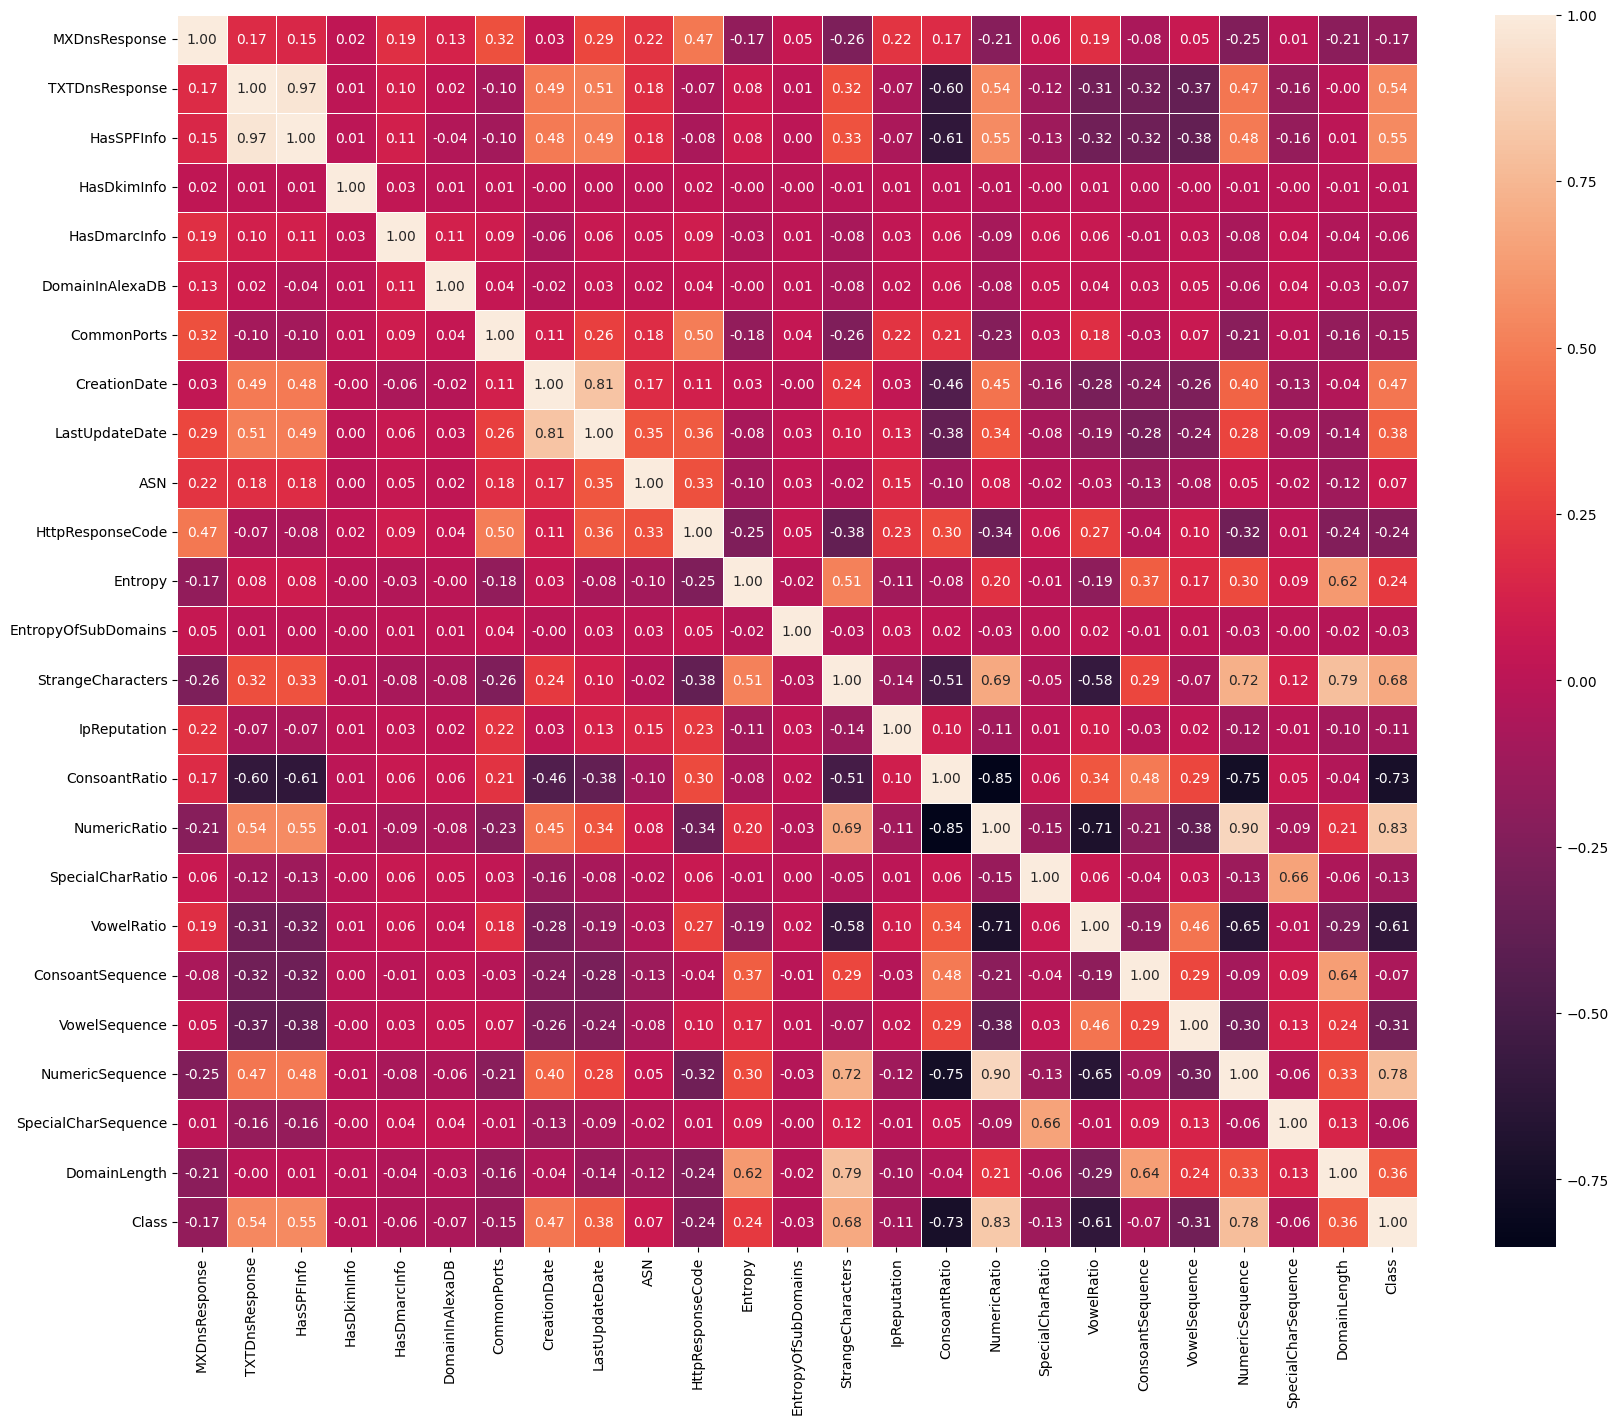

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

# previous test shows these features are not important for determining the class
new_numeric_dataset = new_numeric_dataset.drop(columns=['DomainReputation', 'SubdomainNumber'])

corr_matrix = new_numeric_dataset.corr()
plt.figure(figsize=(20, 16))
sns.heatmap(corr_matrix, annot=True, linewidth=0.5, fmt='.2f')

# Chosen features (based on high correlation with the class)
- TXTDnsResponse
- HasSPFInfo
- StrangeCharacters
- ConsonantRatio
- Numeric ratio
- VowelRatio
- NumericSequence


In [ ]:
new_numeric_dataset = new_numeric_dataset.drop(columns=['DomainReputation', 'SubdomainNumber'])

corr_matrix = new_numeric_dataset.corr()
plt.figure(figsize=(20, 16))
sns.heatmap(corr_matrix, annot=True, linewidth=0.5, fmt='.2f')